# Figures

In [18]:
%load_ext autoreload
%autoreload 2

import collections
import os
import pathlib
import pickle

import joblib
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import powerlaw
import seaborn as sns
from tqdm.auto import tqdm

if 'project_dir' not in globals():
  project_dir = pathlib.Path.cwd().parent
os.chdir(project_dir)

import src.network.distance_distribution
from src.network.cooccurrence import Cooccurrence
import src.network.degree_histogram
import src.network.modularity
import src.network.giant_component
import src.progress_parallel

data_file = 'data/3-process/data.pkl'
network_file = 'networks/8/graph_attributes.pkl'
dutch_network_file = 'networks/8/dutch_graph_attributes.pkl'
giant_component_file = 'networks/8/giant_component.pkl'
dutch_data_file = 'data/3-process/rdw.pkl'
figure_file = 'reports/cn2018/Fig'
distance_distribution_file = 'networks/8/distance_distribution.txt'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Figure 1a

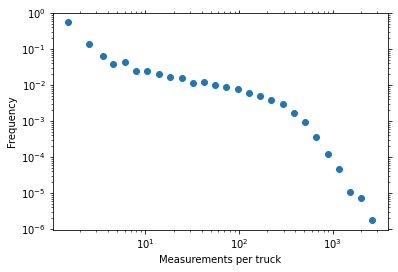

In [2]:
data = pd.read_pickle(data_file)
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True}):
    frequency_list = data['entity'].value_counts().values
    bins = np.logspace(
        start=np.log10(1), 
        stop=np.log10(max(frequency_list)), 
        num=30)
    counts, bins = np.histogram(frequency_list, bins=np.unique(np.round(bins)))
    counts = counts / sum(counts)
    pd.Series(counts, index=bins[:-1] + np.diff(bins)/2).plot(
        marker='o', ls='', loglog=True, xlabel='Measurements per truck', 
        ylabel='Frequency')

plt.savefig(figure_file + '1a.pdf')

## Figure 1b

In [3]:
data = pd.read_pickle(data_file)
time_difference = data.astype({'datetime': int}).groupby(['location', 'entity'])['datetime'].diff()
time_difference = time_difference.dropna() // 3600e9
distribution = time_difference.value_counts(sort=False).sort_index()

In [42]:
df = pd.Series(distribution)
df.index = df.index / 24

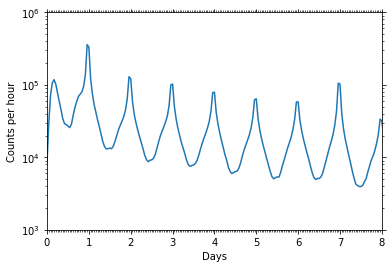

In [47]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True}):
    df.plot(xlabel='Days', ylabel='Counts per hour', xlim=(0,8), logy=True, ylim=(1e3, 1e6))
    plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1/24))
plt.savefig(figure_file + '1b.pdf')

## Figure 2

In [3]:
properties = dict()

for dt_max in tqdm([1, 2, 4, 8, 16, 32, 64, 128, 256, 512]):
    properties[dt_max] = dict()
    g = pd.read_pickle(f'networks/{dt_max}/graph.pkl')
    gc = pd.read_pickle(f'networks/{dt_max}/giant_component.pkl')
    distance_distribution = np.loadtxt(f'networks/{dt_max}/distance_distribution.txt')
    properties[dt_max]['Nodes'] = g.number_of_nodes()
    properties[dt_max]['Nodes in GC'] = gc.number_of_nodes()
    properties[dt_max]['Edges'] = g.number_of_edges()
    properties[dt_max]['Edges in GC'] = gc.number_of_edges()
    properties[dt_max]['Density'] = nx.density(g)
    properties[dt_max]['Density in GC'] = nx.density(gc)
    properties[dt_max]['Diameter'] = src.network.distance_distribution.diameter(distance_distribution)
    properties[dt_max]['Average distance'] = src.network.distance_distribution.average_distance(distance_distribution)

data = pd.DataFrame.from_dict(properties, orient='index')

  0%|          | 0/10 [00:00<?, ?it/s]

### Figure 2a

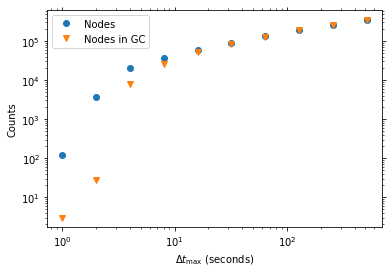

In [4]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    data['Nodes'].plot(marker='o', ls='')
    data['Nodes in GC'].plot(marker='v', ls='')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\Delta t_\mathrm{max}$ (seconds)')
    plt.ylabel('Counts')
    plt.legend()
    plt.savefig(figure_file + '2a.pdf')

### Figure 2b

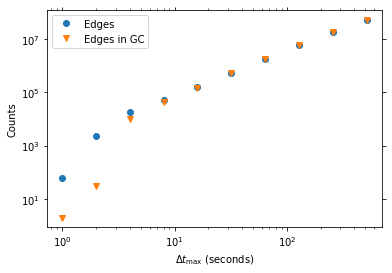

In [5]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    data['Edges'].plot(marker='o', ls='')
    data['Edges in GC'].plot(marker='v', ls='')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\Delta t_\mathrm{max}$ (seconds)')
    plt.ylabel('Counts')
    plt.legend()
    plt.savefig(figure_file + '2b.pdf')

### Figure 2c

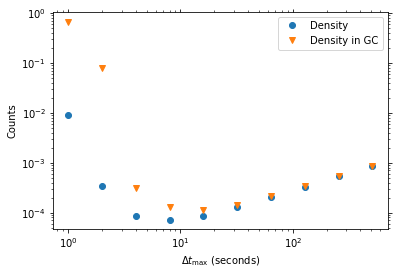

In [6]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    data['Density'].plot(marker='o', ls='')
    data['Density in GC'].plot(marker='v', ls='')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\Delta t_\mathrm{max}$ (seconds)')
    plt.ylabel('Counts')
    plt.legend()
    plt.savefig(figure_file + '2c.pdf')

### Figure 2d

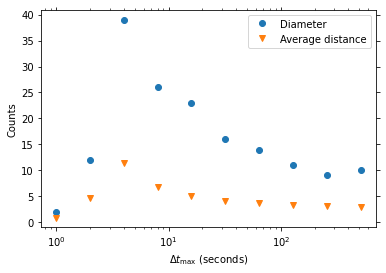

In [7]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    data['Diameter'].plot(marker='o', ls='')
    data['Average distance'].plot(marker='v', ls='')
    plt.xscale('log')
    plt.xlabel(r'$\Delta t_\mathrm{max}$ (seconds)')
    plt.ylabel('Counts')
    plt.legend()
    plt.savefig(figure_file + '2d.pdf')

## Figure 3

### Figure 3a

In [84]:
data = pd.read_pickle('data/3-process/data.pkl')
difference_speed = list()
max_speed = data['velocity'].mean() + 2 * data['velocity'].std()

def check_velocity(a: float, b: float) -> bool:
  return not (np.isnan(a) or np.isnan(b)) and a < 100 and b < 100

with tqdm([2, 4, 8, 16]) as dts:
  for dt_ in dts:
    dts.set_postfix(dt_=dt_)
    # Intentional
    for cooccurrence in tqdm(pd.read_pickle(f'networks/{dt_}/cooccurrences.pkl'), position=1, leave=False):
      velocity_a = cooccurrence.event.attributes['velocity']
      velocity_b = cooccurrence.other_event.attributes['velocity']
      if check_velocity(velocity_a, velocity_b):
        difference_speed.append(
          {'Δt': dt_, 't': 'intentional', 
           'difference in velocity': abs(velocity_b-velocity_a)})
      
    # Random
    for cooccurrence in tqdm(pd.read_pickle(f'networks/{dt_}/randoms.pkl'), position=1, leave=False):
      velocity_a = cooccurrence.event.attributes['velocity']
      velocity_b = cooccurrence.other_event.attributes['velocity']
      if check_velocity(velocity_a, velocity_b):
        difference_speed.append(
          {'Δt': dt_, 't': 'random', 
           'difference in velocity': abs(velocity_b-velocity_a)})

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6130 [00:00<?, ?it/s]

  0%|          | 0/1263142 [00:00<?, ?it/s]

  0%|          | 0/51175 [00:00<?, ?it/s]

  0%|          | 0/4560069 [00:00<?, ?it/s]

  0%|          | 0/131858 [00:00<?, ?it/s]

  0%|          | 0/10217514 [00:00<?, ?it/s]

  0%|          | 0/353635 [00:00<?, ?it/s]

  0%|          | 0/20716669 [00:00<?, ?it/s]

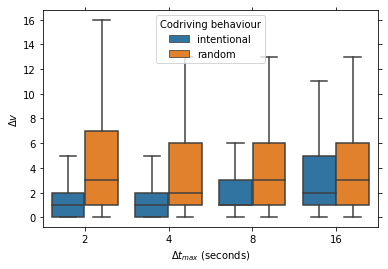

In [97]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    ax = sns.boxplot(data=pd.DataFrame(difference_speed), x='Δt', y='difference in velocity', hue='t', showfliers=False)
    ax.set_xlabel(r'$\Delta t_{max}$ (seconds)')
    ax.set_ylabel(r'$\Delta v$');
    ax.legend(title='Codriving behaviour', loc=9)
    plt.savefig(figure_file + '3a.pdf')

### Figure 3b

In [86]:
lane_difference = list()

for dt_ in tqdm([2, 4, 8, 16], position=0, leave=False):
  # Intentional
  for cooccurrence in tqdm(pd.read_pickle(f'networks/{dt_}/cooccurrences.pkl'), position=1, leave=False):
    lane_a = cooccurrence.event.attributes['lane']
    lane_b = cooccurrence.other_event.attributes['lane']
    if not (np.isnan(lane_a) or np.isnan(lane_b)):
      lane_difference.append(
        {'Δt': dt_, 't': 'intentional', 
         'difference in lane': abs(lane_b-lane_a)})
      
  # Random
  for cooccurrence in tqdm(pd.read_pickle(f'networks/{dt_}/randoms.pkl'), position=1, leave=False):
    lane_a = cooccurrence.event.attributes['lane']
    lane_b = cooccurrence.other_event.attributes['lane']
    if not (np.isnan(lane_a) or np.isnan(lane_b)):
      lane_difference.append(
        {'Δt': dt_, 't': 'random', 
         'difference in lane': abs(lane_b-lane_a)})

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6130 [00:00<?, ?it/s]

  0%|          | 0/1263142 [00:00<?, ?it/s]

  0%|          | 0/51175 [00:00<?, ?it/s]

  0%|          | 0/4560069 [00:00<?, ?it/s]

  0%|          | 0/131858 [00:00<?, ?it/s]

  0%|          | 0/10217514 [00:00<?, ?it/s]

  0%|          | 0/353635 [00:00<?, ?it/s]

  0%|          | 0/20716669 [00:00<?, ?it/s]

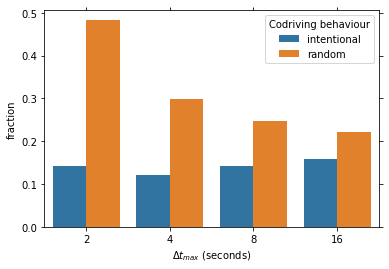

In [98]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    ax = sns.barplot(data=pd.DataFrame(lane_difference), x='Δt', y='difference in lane', hue='t', ci=None)
    ax.set_xlabel(r'$\Delta t_{max}$ (seconds)')
    ax.set_ylabel('fraction');
    ax.legend(title='Codriving behaviour')
    plt.savefig(figure_file + '3b.pdf')


## Figure 4

In [14]:
with open(network_file, 'rb') as file:
    g = pickle.load(file)
with open(dutch_network_file, 'rb') as file:
    dg = pickle.load(file)

### Figure 4a

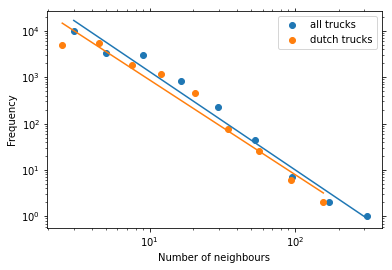

In [15]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    x, y, y_fit = src.network.degree_histogram.degree_histogram(g)
    plt.scatter(x, y, c='C0', label='all trucks')
    plt.plot(x, y_fit, c='C0')

    x, y, y_fit = src.network.degree_histogram.degree_histogram(dg)
    plt.scatter(x, y, c='C1', label='dutch trucks')
    plt.plot(x, y_fit, c='C1')

    plt.xscale("log")
    plt.xlabel("Number of neighbours")

    plt.yscale("log")
    plt.ylabel("Frequency")
    plt.legend()
    plt.savefig(figure_file + '4a.pdf')

### Figure 4b

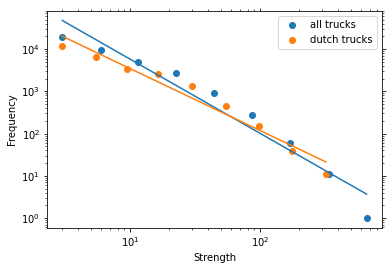

In [16]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    x, y, y_fit = src.network.degree_histogram.degree_histogram(g, weight='weight')
    plt.scatter(x, y, c='C0', label='all trucks')
    plt.plot(x, y_fit, c='C0')

    x, y, y_fit = src.network.degree_histogram.degree_histogram(dg, weight='weight')
    plt.scatter(x, y, c='C1', label='dutch trucks')
    plt.plot(x, y_fit, c='C1')

    plt.xscale("log")
    plt.xlabel("Strength")

    plt.yscale("log")
    plt.ylabel("Frequency")
    plt.legend()
    plt.savefig(figure_file + '4b.pdf')

## Table 1

In [19]:
with open(network_file, 'rb') as file:
    g = pickle.load(file)
with open(giant_component_file, 'rb') as file:
    gc = pickle.load(file)
with open(dutch_network_file, 'rb') as file:
    dg = pickle.load(file)
distance_distribution = np.loadtxt(distance_distribution_file)

full = dict()

full['Number of nodes']                      = g.number_of_nodes()
ngc = gc.number_of_nodes()
fgc = ngc / g.number_of_nodes()
full['Number of nodes in giant component']   = ngc
full['Fraction of nodes in giant component'] = fgc
full['Number of links'] = np.sum(
  [attr for u, v, attr in g.edges(data='weight')])
full['Number of connected node pairs']       = g.number_of_edges()
ngc = gc.number_of_edges()
fgc = ngc / g.number_of_edges()
full['Number of edges in giant component']   = ngc
full['Fraction of edges in giant component'] = fgc
full['Density']                              = nx.density(g)
full['Density in giant component']           = nx.density(gc)
full['Clustering coefficient']               = nx.average_clustering(g)
full['Powerlaw exponent gamma']  = powerlaw.Fit(
  [d for _, d in g.degree], discrete=True, verbose=False).alpha
full['Modularity'] = src.network.modularity.get_modularity(g)

# The following properties were determined using 
# https://github.com/franktakes/teexgraph
full['Diameter'] = src.network.distance_distribution.diameter(
  distance_distribution)
full['Average shortest path length'] = (
  src.network.distance_distribution.average_distance(distance_distribution))

dutch = dict()

dutch['Number of nodes']                      = dg.number_of_nodes()
dgc = src.network.giant_component.giant_component(dg)
ngc = dgc.number_of_nodes()
fgc = ngc / dg.number_of_nodes()
dutch['Number of nodes in giant component']   = ngc
dutch['Fraction of nodes in giant component'] = fgc
dutch['Number of links'] = np.sum(
  [attr for u, v, attr in dg.edges(data='weight')])
dutch['Number of connected node pairs'] = dg.number_of_edges()
ngc = dgc.number_of_edges()
fgc = ngc / dg.number_of_edges()
dutch['Number of edges in giant component']   = ngc
dutch['Fraction of edges in giant component'] = fgc
dutch['Density']                              = nx.density(dg)
dutch['Density in giant component']           = nx.density(dgc)
dutch['Clustering coefficient']               = nx.average_clustering(dg)
dutch['Powerlaw exponent gamma'] = powerlaw.Fit(
  [d for _, d in dg.degree], discrete=True, verbose=False).alpha
dutch['Modularity'] = src.network.modularity.get_modularity(dg)
distance_distribution = (
  src.network.distance_distribution.get_distance_distribution(dgc))
dutch['Diameter'] = src.network.distance_distribution.diameter(
  distance_distribution)
dutch['Average shortest path length'] = (
  src.network.distance_distribution.average_distance(distance_distribution))
table1 = pd.DataFrame(dict(full=full, dutch=dutch))

/scratch/bruingjde/miniconda3/envs/tlp/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


In [31]:
table1

,full,dutch
Number of nodes,37676.000000,27581.000000
Number of nodes in giant component,26353.000000,21015.000000
Fraction of nodes in giant component,0.699464,0.761938
Number of links,131858.000000,103497.000000
Number of connected node pairs,51503.000000,40034.000000
Number of edges in giant component,44564.000000,36848.000000
Fraction of edges in giant component,0.865270,0.920418
Density,0.000073,0.000105
Density in giant component,0.000128,0.000167
Clustering coefficient,0.036760,0.033325


## Table 2

In [20]:
with open(network_file, 'rb') as file:
    g = pickle.load(file)
with open(dutch_network_file, 'rb') as file:
    dg = pickle.load(file)

assortativity = {
    'full': {
        'degree': nx.degree_assortativity_coefficient(g, weight='weight')
    }, 
    'dutch': {
        'degree': nx.degree_assortativity_coefficient(dg, weight='weight')
    }
}
for attribute in ['country', 'v_median', 'nl', 'l_max']:
    assortativity['full'][attribute] = nx.attribute_assortativity_coefficient(g, attribute)

attributes = [
    'nl', 'v_median', 'l_max', 'city', 'm_empty', 'm_max', 'capacity', 'company', 'regdate', 'zip1', 
    'zip2', 'zip3', 'zip4'
]
for attribute in attributes:
    assortativity['dutch'][attribute] = nx.attribute_assortativity_coefficient(dg, attribute)



In [21]:
pd.DataFrame(assortativity)

,full,dutch
degree,0.023618,0.087682
country,0.518090,NaN
v_median,0.054778,0.036926
nl,0.146521,0.118424
l_max,0.567663,0.543310
city,NaN,0.261392
m_empty,NaN,0.020922
m_max,NaN,0.125213
capacity,NaN,0.020789
company,NaN,0.236127


In [22]:
pd.DataFrame(
    {
        label:
        {
            attribute: len({d for _, d in network.nodes(data=attribute)})
            for attribute in ['country', 'l_max', 'city', 'zip1', 'zip2', 'zip3', 'zip4']
        }
        for label, network in [('full', g), ('dutch', dg)]
    }
)
    

,full,dutch
country,22,1
l_max,6,6
city,1,1232
zip1,1,10
zip2,1,91
zip3,1,706
zip4,1,1908


## Figure 5

In [23]:
from community import best_partition, modularity

with open(network_file, 'rb') as file:
    g = pickle.load(file)
gc = src.network.giant_component.giant_component(g)

resolutions = [5e-3, .01, .02, .05, .1, .2, .5, 1, 2]
partitions = {
    r: best_partition(gc, resolution=r) 
    for r in tqdm(resolutions)
}


  0%|          | 0/9 [00:00<?, ?it/s]

### Figure 5a

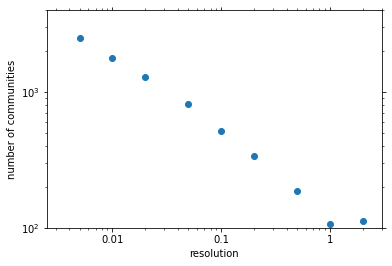

In [24]:
number_of_communities = pd.Series({r: max(p.values()) for r, p in partitions.items()})
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    ax = number_of_communities.plot(
        marker='o', ls='', loglog=True, xlim=(2.5e-3, 3), ylim=(100,4000), 
        xlabel='resolution', ylabel='number of communities'
    )
    ax.set_xticks([.01, .1, 1])
    ax.set_xticklabels([.01, .1, 1])
    plt.savefig(figure_file + '5a.pdf')

### Figure 5b

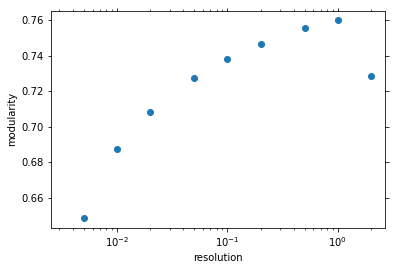

In [25]:
modularity_values = pd.Series({r: modularity(p, gc) for r, p in partitions.items()}) 
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    ax = modularity_values.plot(
        marker='o', ls='', logx=True, xlim=(2.5e-3), xlabel='resolution', ylabel='modularity')
    ax.set_xticks([.01, .1, 1])
    ax.set_xticks([.01, .1, 1])
    plt.savefig(figure_file + '5b.pdf')

## Figure 5c

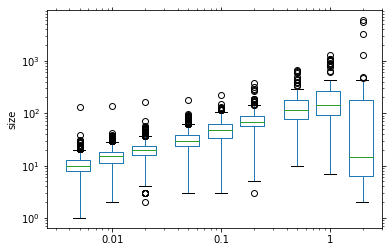

In [26]:
community_size = pd.DataFrame({r: pd.Series(p).value_counts() for r, p in partitions.items()})
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    ax = community_size.plot.box(
    positions=[5e-3, .01, .02, .05, .1, .2, .5, 1, 2], xlim=(2.5e-3, 3), 
    widths=[2.5e-3, 5e-3, .01, .025, .05, .1, .25, .5, 1], loglog=True, 
    xlabel='resolution', ylabel='size')
    ax.set_xticks([.01, .1, 1])
    ax.set_xticklabels([.01, .1, 1])
    plt.savefig(figure_file + '5c.pdf')

## Figure 5d

In [27]:
def get_assortativity_per_community(
        gc: nx.Graph, nodes: list[str], attribute: str):
    if len(nodes) > 2:
        x = nx.attribute_assortativity_coefficient(gc, attribute, nodes=nodes)
        if x is np.nan and attribute == 'country':
            return 1
        else:
            return x

communities_per_resolution = dict()
for resolution, partition in partitions.items():
    communities = collections.defaultdict(list)
    for node, community_id in partition.items():
        communities[community_id].append(node)
    communities_per_resolution[resolution] = communities
    
iterable = [
    (resolution, community_id, nodes, attribute)
    for resolution, communities in communities_per_resolution.items()
    for community_id, nodes in communities.items()
    for attribute in ['country', 'v_median', 'nl', 'l_max']
]

assortativities_per_community = {
  (resolution, community_id, attribute): 
  get_assortativity_per_community(gc, nodes, attribute) 
  for resolution, community_id, nodes, attribute in tqdm(iterable)
}

assortativity_table = (
  pd.Series(assortativities_per_community).unstack().fillna(1))

average_maximal_community_assortativity = {
  resolution: assortativity_table.loc[resolution].max(axis=1).mean() 
  for resolution in resolutions
}      

  0%|          | 0/30700 [00:00<?, ?it/s]

/scratch/bruingjde/miniconda3/envs/tlp/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:263: RuntimeWarning: invalid value encountered in double_scalars
  r = (t - s) / (1 - s)


In [28]:
assortativity_table = (
  pd.Series(assortativities_per_community).unstack().fillna(1).abs())

average_maximal_community_assortativity = {
  resolution: assortativity_table.loc[resolution].max(axis=1).mean() 
  for resolution in resolutions
}

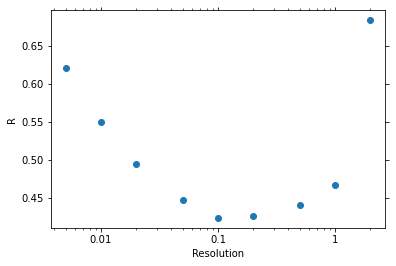

In [29]:
with matplotlib.rc_context({'xtick.top': True, 'ytick.right': True, }):
    pd.Series(average_maximal_community_assortativity).plot(
      marker='o', ls='', logx=True, xlabel='Resolution', ylabel='R')
    plt.xticks([.01, .1, 1], [.01, .1, 1])
    plt.savefig(figure_file + '5d.pdf')

## Table A1
This explains how much of the communities are best explained by given attribute.

In [30]:
assortativity_table.loc[2].idxmax(axis=1).value_counts()

country     61
l_max       44
nl           5
v_median     4
dtype: int64